In [1]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import copy
import pandas as pd
from tqdm import tqdm, tqdm_notebook
from scipy import stats
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

def plcc(x, y):
    """Pearson Linear Correlation Coefficient"""
    x, y = np.float32(x), np.float32(y)
    return stats.pearsonr(x, y)[0]
device  = torch.device("cpu")


PyTorch Version:  1.12.1+cu102
Torchvision Version:  0.13.1+cu102


In [2]:
import pytorch_lightning as pl
print(pl.__version__)

1.8.2


In [3]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from __future__ import print_function, division, absolute_import
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import os
import sys

__all__ = ['InceptionResNetV2', 'inceptionresnetv2']

pretrained_settings = {
    'inceptionresnetv2': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1000
        },
        'imagenet+background': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1001
        }
    }
}


class BasicConv2d(pl.LightningModule):

    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, bias=False) # verify bias false
        self.bn = nn.BatchNorm2d(out_planes,
                                 eps=0.001, # value found in tensorflow
                                 momentum=0.1, # default pytorch value
                                 affine=True)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Mixed_5b(pl.LightningModule):

    def __init__(self):
        super(Mixed_5b, self).__init__()

        self.branch0 = BasicConv2d(192, 96, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(192, 48, kernel_size=1, stride=1),
            BasicConv2d(48, 64, kernel_size=5, stride=1, padding=2)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(192, 64, kernel_size=1, stride=1),
            BasicConv2d(64, 96, kernel_size=3, stride=1, padding=1),
            BasicConv2d(96, 96, kernel_size=3, stride=1, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(192, 64, kernel_size=1, stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Block35(pl.LightningModule):

    def __init__(self, scale=1.0):
        super(Block35, self).__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(320, 32, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(320, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(320, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 48, kernel_size=3, stride=1, padding=1),
            BasicConv2d(48, 64, kernel_size=3, stride=1, padding=1)
        )

        self.conv2d = nn.Conv2d(128, 320, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Mixed_6a(pl.LightningModule):

    def __init__(self):
        super(Mixed_6a, self).__init__()

        self.branch0 = BasicConv2d(320, 384, kernel_size=3, stride=2)

        self.branch1 = nn.Sequential(
            BasicConv2d(320, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=1, padding=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )

        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class Block17(pl.LightningModule):

    def __init__(self, scale=1.0):
        super(Block17, self).__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(1088, 192, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(1088, 128, kernel_size=1, stride=1),
            BasicConv2d(128, 160, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(160, 192, kernel_size=(7,1), stride=1, padding=(3,0))
        )

        self.conv2d = nn.Conv2d(384, 1088, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Mixed_7a(pl.LightningModule):

    def __init__(self):
        super(Mixed_7a, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(1088, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(1088, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 288, kernel_size=3, stride=2)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(1088, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 288, kernel_size=3, stride=1, padding=1),
            BasicConv2d(288, 320, kernel_size=3, stride=2)
        )

        self.branch3 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Block8(pl.LightningModule):

    def __init__(self, scale=1.0, noReLU=False):
        super(Block8, self).__init__()

        self.scale = scale
        self.noReLU = noReLU

        self.branch0 = BasicConv2d(2080, 192, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(2080, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 224, kernel_size=(1,3), stride=1, padding=(0,1)),
            BasicConv2d(224, 256, kernel_size=(3,1), stride=1, padding=(1,0))
        )

        self.conv2d = nn.Conv2d(448, 2080, kernel_size=1, stride=1)
        if not self.noReLU:
            self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        if not self.noReLU:
            out = self.relu(out)
        return out


class InceptionResNetV2(pl.LightningModule):

    def __init__(self, num_classes=1001):
        super(InceptionResNetV2, self).__init__()
        # Special attributs
        self.input_space = None
        self.input_size = (299, 299, 3)
        self.mean = None
        self.std = None
        # Modules
        self.conv2d_1a = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.conv2d_2a = BasicConv2d(32, 32, kernel_size=3, stride=1)
        self.conv2d_2b = BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool_3a = nn.MaxPool2d(3, stride=2)
        self.conv2d_3b = BasicConv2d(64, 80, kernel_size=1, stride=1)
        self.conv2d_4a = BasicConv2d(80, 192, kernel_size=3, stride=1)
        self.maxpool_5a = nn.MaxPool2d(3, stride=2)
        self.mixed_5b = Mixed_5b()
        self.repeat = nn.Sequential(
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17)
        )
        self.mixed_6a = Mixed_6a()
        self.repeat_1 = nn.Sequential(
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10)
        )
        self.mixed_7a = Mixed_7a()
        self.repeat_2 = nn.Sequential(
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20)
        )
        self.block8 = Block8(noReLU=True)
        self.conv2d_7b = BasicConv2d(2080, 1536, kernel_size=1, stride=1)
        self.avgpool_1a = nn.AvgPool2d(8, count_include_pad=False)
        self.last_linear = nn.Linear(1536, num_classes)

    def features(self, input):
        x = self.conv2d_1a(input)
        x = self.conv2d_2a(x)
        x = self.conv2d_2b(x)
        x = self.maxpool_3a(x)
        x = self.conv2d_3b(x)
        x = self.conv2d_4a(x)
        x = self.maxpool_5a(x)
        x = self.mixed_5b(x)
        x = self.repeat(x)
        x = self.mixed_6a(x)
        x = self.repeat_1(x)
        x = self.mixed_7a(x)
        x = self.repeat_2(x)
        x = self.block8(x)
        x = self.conv2d_7b(x)
        return x

    def logits(self, features):
        x = self.avgpool_1a(features)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x

def inceptionresnetv2(num_classes=1000, pretrained='imagenet'):
    r"""InceptionResNetV2 model architecture from the
    `"InceptionV4, Inception-ResNet..." <https://arxiv.org/abs/1602.07261>`_ paper.
    """
    if pretrained:
        settings = pretrained_settings['inceptionresnetv2'][pretrained]
        assert num_classes == settings['num_classes'], \
            "num_classes should be {}, but is {}".format(settings['num_classes'], num_classes)

        # both 'imagenet'&'imagenet+background' are loaded from same parameters
        model = InceptionResNetV2(num_classes=1001)
        model.load_state_dict(model_zoo.load_url(settings['url']))

        if pretrained == 'imagenet':
            new_last_linear = nn.Linear(1536, 1000)
            new_last_linear.weight.data = model.last_linear.weight.data[1:]
            new_last_linear.bias.data = model.last_linear.bias.data[1:]
            model.last_linear = new_last_linear

        model.input_space = settings['input_space']
        model.input_size = settings['input_size']
        model.input_range = settings['input_range']

        model.mean = settings['mean']
        model.std = settings['std']
    else:
        model = InceptionResNetV2(num_classes=num_classes)
    return model

In [4]:
from inceptionresnetv2 import inceptionresnetv2

class model_qa(pl.LightningModule):
    def __init__(self,num_classes,**kwargs):
        super(model_qa,self).__init__()
        base_model = inceptionresnetv2(num_classes=1000, pretrained=None)
        self.base= nn.Sequential(*list(base_model.children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(1536, 2048),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(2048),
            nn.Dropout(p=0.25),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.25),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),         
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes),
        )
        self.optimizer = optim.Adam(self.parameters(), lr=0.01)
    def mse_loss(self, outputs, labels):
        return torch.nn.MSELoss()(outputs, labels)
    
    def forward(self,x):
        x = self.base(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.float()
        return x    
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        x = x.float()
        y = y.float()
        outputs = self.forward(x)
        loss = self.mse_loss(outputs, y)
        self.log('train_loss', loss)
        self.log('train_loss', loss)
        return loss 
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        x = x.float()
        y = y.float()
        outputs = self.forward(x)
        loss = self.MSEloss(outputs, y)
        self.log('val_loss', loss)
        loss_mae = nn.L1Loss()(outputs.to(torch.float32), y)
        return {'mse': loss, 'mae': loss_mae}
    
    def training_epoch_end(self, training_step_outputs):
        loss = torch.stack([f['loss'] for f in training_step_output]).mean()
        print('tranining loss: ',loss)
        torch.cuda.empty_cache()
    
    def validate_epoch_end(self, validation_step_outputs):
        loss_mse = torch.stack([f['mse'] for f in validation_step_outputs]).mean()
        loss_mae = torch.stack([f['mae'] for f in validation_step_outputs]).mean()
        print('mse: ', loss_mse)
        print('mae: ', loss_mae)
        torch.cuda.empty_cache()
        
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [5]:
import torch.utils.data as data

class CustomImageDataset(Dataset):

    def __init__(self, root):
        self.root = root
    
        self.samples = []
        self.list_label = []
        for i in range(5):
            self.samples.extend([root + '/' + str(i) + '/' + path_image for path_image in os.listdir(root + '/' + str(i))])
            for a in range(len(os.listdir(root + '/' + str(i)))):
                self.list_label.append(i)
        self.transform = self.img_transform(224)

    def __getitem__(self, index):
        target = self.list_label[index]
        sample = Image.open(self.samples[index])
        sample = self.transform(sample)
        return sample, target

    def __len__(self):
        length = len(self.samples)
        return length

    def img_transform(self, crop_size):
#         normalize = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        return transforms.Compose([
            transforms.Resize([512,384]),
#             RandomCrop(crop_size),
#             transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
#             normalize
            ])

0


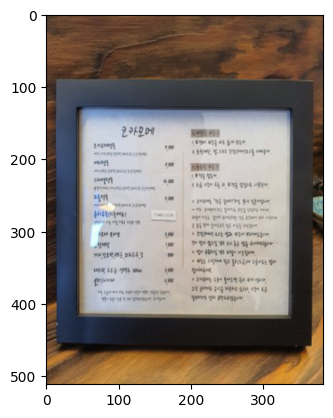

In [6]:
abc = CustomImageDataset('train_under_sample')
img, label = abc.__getitem__(200)
a = abc.__init__('train_under_sample')
plt.imshow(img.permute(1, 2, 0))
print(label)


In [7]:
class DataModule(pl.LightningDataModule):

    def setup(self, stage):
        # transforms for images
        data_transforms = {
            'train': transforms.Compose([
        #         transforms.RandomResizedCrop(input_size),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        #         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

            ]),
            'val': transforms.Compose([
        #         transforms.Resize(input_size),
        #         transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ]),
        }
                                                
#         self.data_train = CustomImageDataset('train_under_sample', False)
        self.data_test = CustomImageDataset('train_under_sample', False)
        
                       
#     def train_dataloader(self):
#         return DataLoader(self.data_train, batch_size=2)

    def val_dataloader(self):
        return DataLoader(self.data_test, batch_size=8, shuffle=True)


In [8]:
model1 = torch.load("../jupyter/epoch=9-step=262060.ckpt", map_location=torch.device('cpu'))
# model1 = torch.load("../jupyter/epoch=0-step=6552.ckpt", map_location=torch.device('cpu'))
model2 = model_qa(1)
model2.load_state_dict(model1['state_dict'], strict=False)

<All keys matched successfully>

In [9]:
def rating_metrics(y_true, y_pred, show_plot=True):    
    """
    Print out performance measures given ground-truth (`y_true`) and predicted (`y_pred`) scalar arrays.
    """
    y_true, y_pred = np.array(y_true).squeeze(), np.array(y_pred).squeeze()
    p_mae  = np.round(np.mean(np.abs(y_true - y_pred)),3)
    p_rmse  = np.round(np.sqrt(np.mean((y_true - y_pred)**2)),3)
    
    if show_plot:
        print('MAE: {} | RMSE: {}'.
              format(p_mae, p_rmse))    
        plt.plot(y_true, y_pred,'.',markersize=1)
        plt.xlabel('ground-truth')
        plt.ylabel('predicted')
        plt.show()
    return (p_mae, p_rmse)

MAE: 1.355 | RMSE: 1.711


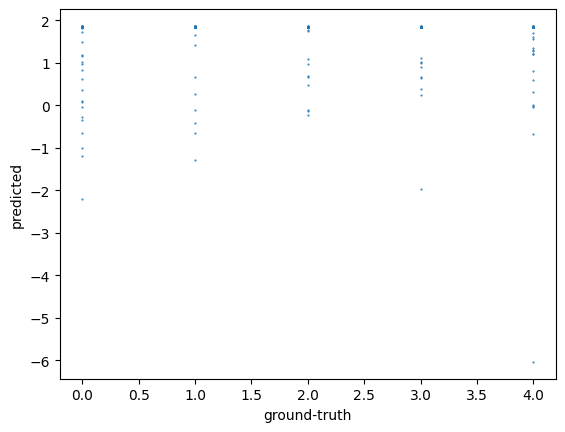

(1.355, 1.711)

In [35]:
import glob
model2.eval()
list_pred = []
list_true = []
for i in range(5):
    test_dir = 'train_under_sample/'
    test_dir+=str(i)
    test_img_path = glob.glob(os.path.join(test_dir, '*.jpg'))
    convert_tensor = transforms.Compose([
                transforms.Resize([512,384]),   
                transforms.ToTensor(),
                ])
    for image in test_img_path[:50]:
        img = Image.open(image)
        img = convert_tensor(img)
        img = img.unsqueeze(0)
        img = img.to(device  = torch.device("cpu"))
        outputs = model2(img)
        list_pred.append(outputs.detach().numpy()[0])
        list_true.append(i)

rating_metrics(list_true, list_pred)
    

In [ ]:
import glob
def srocc(xs, ys):
    """Spearman Rank Order Correlation Coefficient"""
    xranks = pd.Series(xs).rank()    
    yranks = pd.Series(ys).rank()    
    return plcc(xranks, yranks)
def rating_metrics(y_true, y_pred, show_plot=True):    
    """
    Print out performance measures given ground-truth (`y_true`) and predicted (`y_pred`) scalar arrays.
    """
    y_true, y_pred = np.array(y_true).squeeze(), np.array(y_pred).squeeze()
    p_plcc = np.round(plcc(y_true, y_pred),3)
    p_srocc = np.round(srocc(y_true, y_pred),3)
    p_mae  = np.round(np.mean(np.abs(y_true - y_pred)),3)
    p_rmse  = np.round(np.sqrt(np.mean((y_true - y_pred)**2)),3)
    
    if show_plot:
        print('SRCC: {} | PLCC: {} | MAE: {} | RMSE: {}'.\
              format(p_srocc, p_plcc, p_mae, p_rmse))    
        plt.plot(y_true, y_pred,'.',markersize=1)
        plt.xlabel('ground-truth')
        plt.ylabel('predicted')
        plt.show()
    return (p_srocc, p_plcc, p_mae, p_rmse)
test_dir = 'train_under_sample/0'
test_img_path = glob.glob(os.path.join(test_dir, '*.jpg'))
ids = test_img_path

# ids_train = ids[ids.set=='training'].reset_index()
# ids_val = ids[ids.set=='validation'].reset_index()
ids_test = ids[:100]


batch_size=1
num_batches = np.int(np.ceil(len(ids_test)/batch_size))
convert_tensor = transforms.Compose([
            transforms.Resize([384,512]),   
            transforms.ToTensor(),
            ])

# Iterate over data.
outputs=np.zeros((len(ids_test),1))
img_batch=torch.zeros(1,3,384,512).to(device)     
img_batch[0]=convert_tensor(Image.open(ids_test[0])) 
outputs = model2(img_batch).detach().cpu().numpy()
 



y_true = 0
rating_metrics(y_true, outputs)
print('y_true: ', y_true)
print('output: ', outputs)

In [ ]:
# def prediction(test_img_path, model, device):
#     id_list = []
#     pred_list = []
#     convert_tensor = transforms.Compose([
#             transforms.Resize([512,384]),   
#             transforms.ToTensor(),
#             ])

#     with torch.no_grad():
#         for path in tqdm(test_img_path):
#             i = 1
#             _id = 0
#             img = Image.open(path)
#             _id += i
#             img = convert_tensor(img)
#             img = img.unsqueeze(0)
#             img = img.to(device)
            
#             model.eval()
#             outputs = model(img)
#             preds = F.softmax(outputs).tolist()

#             id_list.append(_id)
#             pred_list.append(preds[0])

#     # Result DataFrame
#     res = pd.DataFrame({
#         'id': id_list,
#         'label': pred_list
#     })
    
#     # Submit
#     res.sort_values(by='id', inplace=True)
    
#     return res, pred_list

In [ ]:
# import os, glob
# test_dir = 'train_under_sample/4'
# test_img_path = glob.glob(os.path.join(test_dir, '*.jpg'))
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# res, pred_list = prediction(test_img_path[100:105], model2, device)

In [ ]:
# from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
# save_dir = '../jupyter'
# data_module = DataModule()
# model = model_qa(num_classes=1)

# checkpoint_callback = ModelCheckpoint(dirpath=save_dir, save_weights_only=True)

# trainer = pl.Trainer( devices=1, default_root_dir=save_dir, max_epochs=1, auto_select_gpus=True)
# trainer.fit(model, data_module)

In [ ]:
# trainer.validate(model, data_module)